Импортируем всякое

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, \
                    GridSearchCV, \
                    cross_val_score, \
                    StratifiedKFold, \
                    RandomizedSearchCV
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [3]:
import xgboost as xgb


In [69]:
def maxi(x):
    rez = max(x)
    for i in range(len(x)):
        if (x[i] == rez):
            return (rez, i)

Вдруг придётся преоткрыть

In [4]:
train = None
test = None
def reload_data():
    return (pd.read_csv("../data/raw/application_train.csv"), pd.read_csv("../data/raw/application_test.csv"))

Избавимся от y\n во флагах

In [5]:
def flag_to_int(df):
    for i in df:
        if "FLAG" in i:
            df[i] = np.where((df[i] == 'Y') | (df[i] == 'y') | (df[i] == 1), 1, 0)

In [6]:
train, test = reload_data()

In [7]:
flag_to_int(train)
flag_to_int(test)

In [8]:
target = "TARGET"

Достаём часть данных, чтобы ускорить работу

In [9]:
def join_(df):
    return df.join(pd.read_csv("../data/raw/bureau.csv"), on='SK_ID_CURR', how='inner', rsuffix='_b').join(pd.read_csv("../data/raw/credit_card_balance.csv"), on='SK_ID_CURR', how='inner', rsuffix='_ccb').join(pd.read_csv("../data/raw/previous_application.csv"), on='SK_ID_CURR', how='inner', rsuffix='_pa').join(pd.read_csv("../data/raw/POS_CASH_balance.csv"), on='SK_ID_CURR', how='inner', rsuffix='_pcb')
    

Функция для тестиования и измерения orc auc

In [10]:
def comp_roc(df, features, target = "TARGET"):
    kf = KFold(n_splits=5, shuffle=True) #random_state=42)
    
    roc_list = []
    for i, (train_index, val_index) in enumerate(kf.split(df)):
        train_part = df.iloc[train_index, : ]
        train_x = train_part[features]
        train_y = train_part[target]
        
        val_part = df.iloc[val_index, :]
        test_x = val_part[features]
        test_y = val_part[target]
        
        model = LogisticRegression()
        
        model.fit(train_x, train_y)
        
        y_score = model.predict_proba(test_x)[:,1]

        roc_auc = roc_auc_score(test_y, y_score)

        print(f'Fold full {i}: roc_auc {roc_auc}, count values {y_score}')
        roc_list.append(roc_auc)

        
    print(f'roc average = {np.mean(roc_list)}, std = {np.std(roc_list)}')

Функция для тестирования и подсчёта msle

In [11]:

def comp_mse(df, features, target):
    kf = KFold(n_splits=5, shuffle=True) #random_state=42)
    
    msle_list = []
    mse_list = []
    for i, (train_index, val_index) in enumerate(kf.split(df)):    
        train_part = df.iloc[train_index, : ]
        val_part = df.iloc[val_index, :]
        model = SGDRegressor()
        model.fit(X=train_part[features].fillna(0), y = train_part[target])
        val_predication = model.predict(val_part[features].fillna(0)).clip(0, 100000000000)

        mse = mean_squared_error(val_predication, val_part[target])
        msle = mean_squared_log_error(val_predication, val_part[target])

        
        print(f'Fold full {i}: msle {msle}, mse {mse}')
        msle_list.append(msle)
        mse_list.append(mse)
        
    print(f'MSLE average = {np.mean(msle_list)}, std = {np.std(msle_list)}')
    

In [12]:
def predict_n_write_csv(features, path="predict1.csv"):
    target = "TARGET"
    
    model = LogisticRegression()
    train_part_x = train[features].fillna(0)
    train_part_y = train[target]
    model.fit(X=train_part_x, y = train_part_y)
    
    sample_submission = pd.read_csv("../data/raw/sample_submission.csv")
    sample_submission[target] = model.predict(test[features]) 
    sample_submission.to_csv(path, index= False)

Подготовка данных

In [13]:
def prepare_data(train, x1, test=None, x2=None):
    train = x1(train)
    if x2 != None:
        test = x2(test)
    return (train, test)

Подцепим флаги из осного сета

In [14]:
flags = ["FLAG_MOBIL", "FLAG_EMP_PHONE", "FLAG_CONT_MOBILE", "FLAG_EMAIL", "REG_REGION_NOT_WORK_REGION",
        # "DAYS_LAST_PHONE_CHANGE", 'REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION',
         'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY',
            'FLAG_OWN_REALTY', 'FLAG_OWN_CAR']

In [15]:
train_p = train[train[target] == 1]
train_m = train[train[target] == 0].sample(train_p.shape[0])

In [16]:
train_1 = train_p.append(train_m)

In [17]:
from sklearn.preprocessing import LabelEncoder

In [18]:
def print_object_and_convert_bits(train_1):
    i = 0
    for i in train_1:
        if train_1.dtypes[i] == object:
            if len(train_1["NAME_CONTRACT_TYPE"].unique())  == 2:
                LE = LabelEncoder()
                train_1[i] = LE.fit_transform(train_1[i])

            else:
                print(i, "\t\t", train_1.dtypes[i])
                i += 1
    if i == 0:
        print("only bits")

In [20]:
print_object_and_convert_bits(train_1)


In [21]:
model = xgb.XGBClassifier()
model.fit(train_1.drop(target, axis=1), train_1[target])

[17:28:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
print_object_and_convert_bits(test)
y_pred = model.predict(test)
predictions = [round(value) for value in y_pred]

In [23]:
sample_submission = pd.read_csv("../data/raw/sample_submission.csv")
sample_submission[target] = y_pred
sample_submission.to_csv("first_predict.csv", index= False)

### Private Score 0.67256
### Public Score 0.67929

По заданию

In [26]:
 = join_(train_1)

In [27]:
print_object_and_convert_bits(train_1)

In [28]:
train_1

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,SK_ID_PREV_pcb,SK_ID_CURR_pcb,MONTHS_BALANCE_pcb,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS_pcb,SK_DPD_pcb,SK_DPD_DEF_pcb
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,...,-1908.0,0.0,2415125,200227,-32,12.0,12.0,0,0,0
26,100031,1,0,0,0,1,0,112500.0,979992.0,27076.5,...,-258.0,1.0,2706181,135757,-38,6.0,6.0,0,0,0
40,100047,1,0,1,0,1,0,202500.0,1193580.0,35028.0,...,-546.0,1.0,1940977,138382,-2,12.0,2.0,0,0,0
42,100049,1,0,0,0,0,0,135000.0,288873.0,16258.5,...,NaN,NaN,2674796,384799,-10,36.0,16.0,0,0,0
81,100096,1,0,0,0,1,0,81000.0,252000.0,14593.5,...,NaN,NaN,2726442,245973,-7,13.0,0.0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272760,416187,0,0,1,1,1,0,112500.0,1087366.5,31923.0,...,NaN,NaN,2748910,235906,-53,30.0,1.0,0,0,0
64909,175270,0,0,0,1,1,0,450000.0,1546020.0,40783.5,...,-2251.0,0.0,2607838,198900,-9,36.0,21.0,0,0,0
114394,232658,0,0,1,0,1,1,121500.0,225000.0,11074.5,...,-1027.0,0.0,2272203,343209,-25,10.0,3.0,0,0,0
223704,359104,0,0,0,0,1,0,112500.0,1125000.0,32895.0,...,NaN,NaN,1671452,296280,-49,12.0,2.0,0,0,0


In [ ]:
model = xgb.XGBClassifier()

In [58]:
parameters = {'nthread':[4],
              'objective':['binary:logistic'],
              'learning_rate': [0.05],
              'max_depth': range(1, 7),
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': range(3,8),
              'missing':[-999],
              'seed': [1337]}


clf = GridSearchCV(model, parameters, n_jobs=5, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True),
                   scoring='roc_auc',
                   verbose=2, refit=True)

clf.fit(train_1.drop(target, axis=1), train_1[target])


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=range(1, 7), min_child_weight=11, missing=-999, n_estimators=range(3, 8), nthread=4, objective=binary:logistic, seed=1337, silent=1, subsample=0.8; total time=   0.2s
[18:28:03] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:28:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=1, min_child_weight=11, missing=-999, n_

[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=range(1, 7), min_child_weight=11, missing=-999, n_estimators=range(3, 8), nthread=4, objective=binary:logistic, seed=1337, silent=1, subsample=0.8; total time=   0.2s
[18:28:03] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:28:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=1, min_child_weight=11, missing=-999, n_estimators=3, nthread=4, objective=binary:logistic, seed=1337,

/home/andru/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andru/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andru/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

/home/andru/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andru/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andru/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=2, min_child_weight=11, missing=-999, n_estimators=7, nthread=4, objective=binary:logistic, seed=1337, silent=1, subsample=0.8; total time=   1.2s
[18:28:12] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:28:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, min_child_weight=11, missing=-999, n_estimators=3, nthread=4, objective=binary:logistic, seed=1337, silent=1, subsample

[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=4, min_child_weight=11, missing=-999, n_estimators=7, nthread=4, objective=binary:logistic, seed=1337, silent=1, subsample=0.8; total time=   2.4s
[18:28:27] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:28:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, missing=-999, n_estimators=3, nthread=4, objective=binary:logistic, seed=1337, silent=1, subsample

[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=4, min_child_weight=11, missing=-999, n_estimators=7, nthread=4, objective=binary:logistic, seed=1337, silent=1, subsample=0.8; total time=   2.2s
[18:28:28] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:28:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_weight=11, missing=-999, n_estimators=3, nthread=4, objective=binary:logistic, seed=1337, silent=1, subsample

/home/andru/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:28:50] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:28:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=-1, importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weigh...
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
                                     verbosity=None),
             n_jobs=5,
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.05],
                

In [59]:
clf.cv_results_

{'mean_fit_time': array([0.66224499, 0.71892977, 0.78048882, 0.84588103, 0.88025627,
        0.77139254, 0.88258176, 0.98155403, 1.1235806 , 1.17926841,
        0.87364964, 1.10652065, 1.25857639, 1.47057433, 1.60815501,
        1.08856688, 1.30723848, 1.63559833, 1.83993645, 2.4305512 ,
        1.32007523, 1.72751637, 1.97278786, 2.14415712, 2.55757103,
        1.44982572, 1.96283545, 2.11128435, 2.62360325, 2.89891081]),
 'std_fit_time': array([0.02221718, 0.02558428, 0.03594242, 0.03570055, 0.03325041,
        0.0361022 , 0.07433078, 0.04287862, 0.10601879, 0.04435179,
        0.06078401, 0.08286941, 0.07045421, 0.07698871, 0.10311997,
        0.08751746, 0.05355422, 0.08195888, 0.16309078, 0.16813131,
        0.18979523, 0.03263787, 0.20421059, 0.15690695, 0.2624887 ,
        0.11627625, 0.16001514, 0.08245214, 0.19288925, 0.21908936]),
 'mean_score_time': array([0.03896122, 0.03738155, 0.04585795, 0.05064702, 0.04610353,
        0.04689531, 0.05376954, 0.06228809, 0.05759311, 0.05

In [60]:
for i in clf.cv_results_.keys():
    print (i)

mean_fit_time
std_fit_time
mean_score_time
std_score_time
param_colsample_bytree
param_learning_rate
param_max_depth
param_min_child_weight
param_missing
param_n_estimators
param_nthread
param_objective
param_seed
param_silent
param_subsample
params
split0_test_score
split1_test_score
split2_test_score
split3_test_score
split4_test_score
mean_test_score
std_test_score
rank_test_score


In [74]:
score, i = maxi(clf.cv_results_['mean_test_score'])
params = clf.cv_results_['params'][i]
print (score, "\n", params)

0.7339499882865862 
 {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 7, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1337, 'silent': 1, 'subsample': 0.8}


теперь RandomizedSearchCV

In [98]:
model = xgb.XGBClassifier(use_label_encoder=False)
parameters = {'nthread':[4],
              'objective':['binary:logistic'],
              'learning_rate': [0.001, 0.05, 0.1, 0.2, 0,3],
              'max_depth': range(1, 20),
              'min_child_weight': np.arange(0.5, 20, 0.5),
              'gamma': [0, 0.25, 0.5, 1.0],
              'subsample': np.arange(0.4, 1, 0.1),
              'colsample_bytree': [0.7],
              'n_estimators': [3,10, 20, 50, 100],
              'missing':[-999],
              'seed': [1337]}
fit_params = {'eval_metric': 'mlogloss',
              'early_stopping_rounds': 10}

In [99]:
rs_clf = RandomizedSearchCV(model, parameters, n_iter=20,
                            n_jobs=5, verbose=2,
                            cv=StratifiedKFold(n_splits=5, shuffle=True),
                            scoring='roc_auc', refit=True, random_state=42)

In [100]:
rs_clf.fit(train_1.drop(target, axis=1), train_1[target])
#            **, fit_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[19:50:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=3, max_depth=10, min_child_weight=5.0, missing=-999, n_estimators=10, nthread=4, objective=binary:logistic, seed=1337, subsample=0.6; total time=   5.0s
[19:50:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=3, max_depth=18, min_child_weight=15.0, missing=-999, n_estimators=50, nthread=4, objective=binary:logistic, seed=1337, subsample=0.7999999999999999; total time=   8.0s
[19:

[19:50:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=3, max_depth=10, min_child_weight=5.0, missing=-999, n_estimators=10, nthread=4, objective=binary:logistic, seed=1337, subsample=0.6; total time=   5.1s
[19:50:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=3, max_depth=18, min_child_weight=15.0, missing=-999, n_estimators=50, nthread=4, objective=binary:logistic, seed=1337, subsample=0.7999999999999999; total time=   7.7s
[19:50:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.

[19:50:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=3, max_depth=10, min_child_weight=5.0, missing=-999, n_estimators=10, nthread=4, objective=binary:logistic, seed=1337, subsample=0.6; total time=   4.2s
[19:50:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=3, max_depth=18, min_child_weight=15.0, missing=-999, n_estimators=50, nthread=4, objective=binary:logistic, seed=1337, subsample=0.7999999999999999; total time=   7.5s
[19:50:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.

[20:00:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=No...
                                        'min_child_weight': array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
        6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. ,
       11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 1

In [103]:
print(rs_clf.best_score_, rs_clf.best_params_)

0.7413391788846193 {'subsample': 0.7999999999999999, 'seed': 1337, 'objective': 'binary:logistic', 'nthread': 4, 'n_estimators': 20, 'missing': -999, 'min_child_weight': 18.0, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0, max_depth=13, min_child_weight=7.0, missing=-999, n_estimators=3, nthread=4, objective=binary:logistic, seed=1337, subsample=0.8999999999999999; total time=   2.6s
[19:59:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0, max_depth=13, min_child_weight=7.0, missing=-999, n_estimators=3, nthread=4, objective=binary:logistic, seed=1337, subsample=0.8999999999999999; total time=   3.7s
[19:59:36] WARNING: ../src/learner.cc:1115: Starting in

In [110]:
model = xgb.XGBClassifier(use_label_encoder=False, **rs_clf.best_params_)
model.fit(train_1.drop(target, axis=1), train_1[target])

[20:13:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=18.0, missing=-999, monotone_constraints='()',
              n_estimators=20, n_jobs=4, nthread=4, num_parallel_tree=1,
              predictor='auto', random_state=1337, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=1337, subsample=0.7999999999999999,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

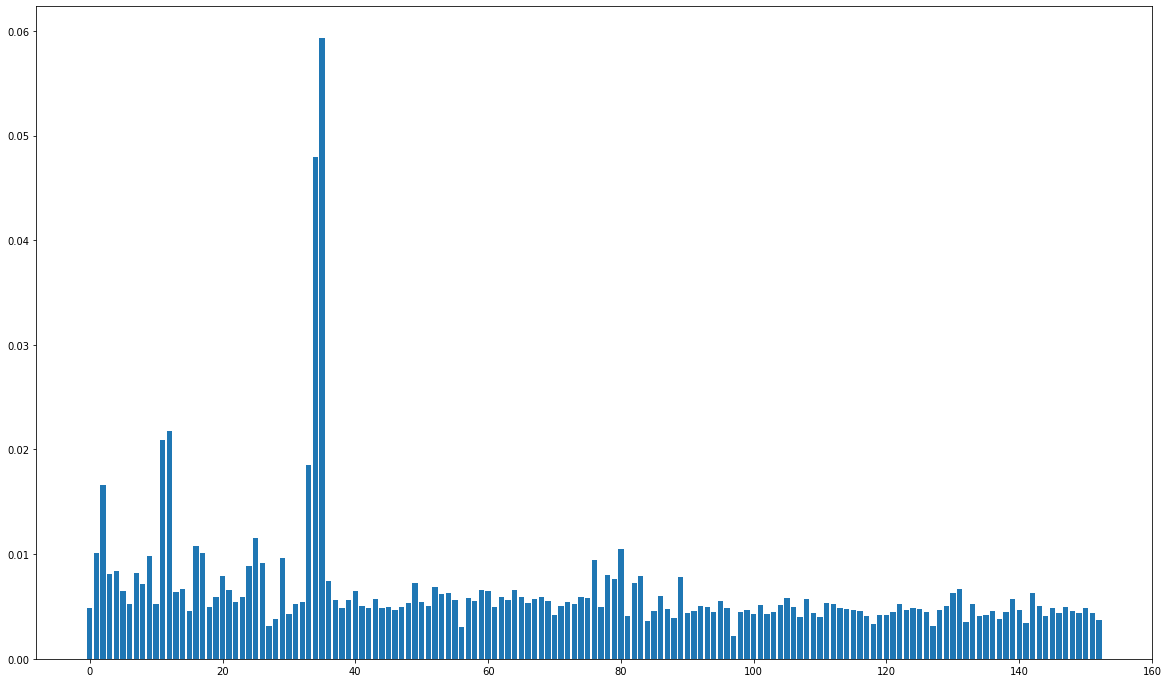

In [118]:
importance = list(filter(lambda x: x > 0.001, model.feature_importances_))
plt.figure(figsize=(20,12))
plt.bar([x for x in range(len(importance))], importance)
plt.show()